# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')


import warnings
warnings.filterwarnings("ignore")



from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

# Loading data 

In [3]:
# Get Data
df = pd.read_csv('Metabolic  Syndrome.csv')
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


# Explore Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seqn               int64  
 1   Age                int64  
 2   Sex                object 
 3   Marital            object 
 4   Income             float64
 5   Race               object 
 6   WaistCirc          float64
 7   BMI                float64
 8   Albuminuria        int64  
 9   UrAlbCr            float64
 10  UricAcid           float64
 11  BloodGlucose       int64  
 12  HDL                int64  
 13  Triglycerides      int64  
 14  MetabolicSyndrome  object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


In [5]:
df.isna().sum()#.sum()

seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

In [6]:
df.isna().sum()/len(df)*100

seqn                 0.000000
Age                  0.000000
Sex                  0.000000
Marital              8.663057
Income               4.872970
Race                 0.000000
WaistCirc            3.540192
BMI                  1.082882
Albuminuria          0.000000
UrAlbCr              0.000000
UricAcid             0.000000
BloodGlucose         0.000000
HDL                  0.000000
Triglycerides        0.000000
MetabolicSyndrome    0.000000
dtype: float64

In [7]:
df['MetabolicSyndrome'].value_counts()/len(df)*100

No MetSyn    65.764265
MetSyn       34.235735
Name: MetabolicSyndrome, dtype: float64

In [8]:
df.shape

(2401, 15)

---

- My Target would be : MetabolicSyndrome
- Each Row represents : A Person
- Number of Features The Dataframe includes : 15 
- Number of Row the Dataframe includes : 2401
- The Target's Values are not balanced, we will be using a Balancing method (Smote)
- Initially, we will be using all of the 15 features, and test importance later on
- we have a total of 436 missing values that we will need to impute during our modeling
    
---

# Basic Visualization

## needed function for visualization

In [9]:
# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT

#old function did not have an if statement ---------------------------- to make a histoplot for 'class'

  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax



In [10]:
# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False , ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df

    
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax


## Visualization

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Marital vs. MetabolicSyndrome'}, xlabel='Marital', ylabel='Percent'>)

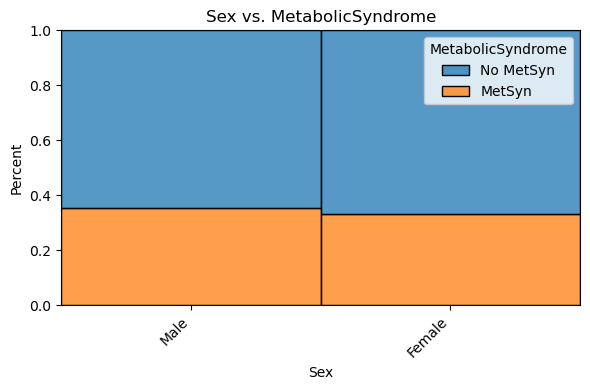

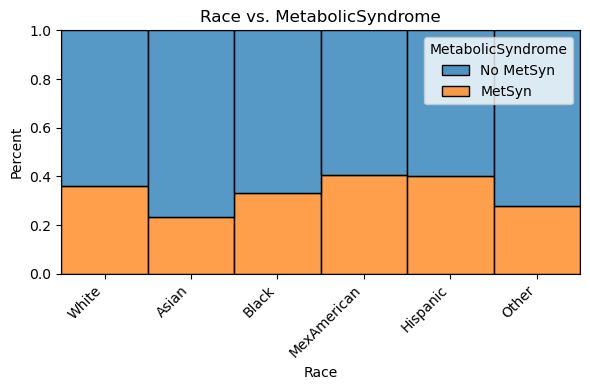

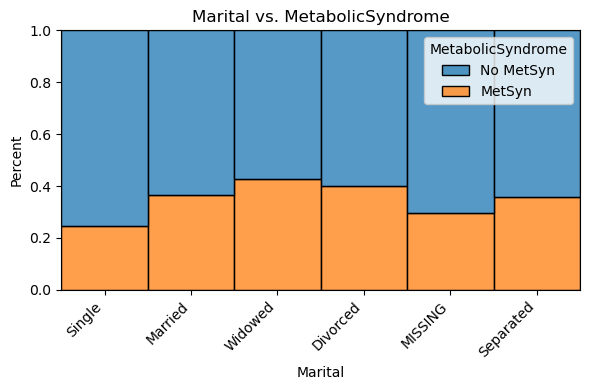

In [11]:
plot_categorical_vs_target(df, 'Sex', 'MetabolicSyndrome', target_type='class')

plot_categorical_vs_target(df, 'Race', 'MetabolicSyndrome', target_type='class')

plot_categorical_vs_target(df, 'Marital', 'MetabolicSyndrome', target_type='class')

---

- we cannot explore alot from these plots, but from the fight sight we can say that the only statement we can be sure of, is that Asians(race) and single people(martial status) tend to have less probability to have metabolic syndrome than other categories we have in out data


---

- Excluding 117 NaN's
- Excluding 26 NaN's


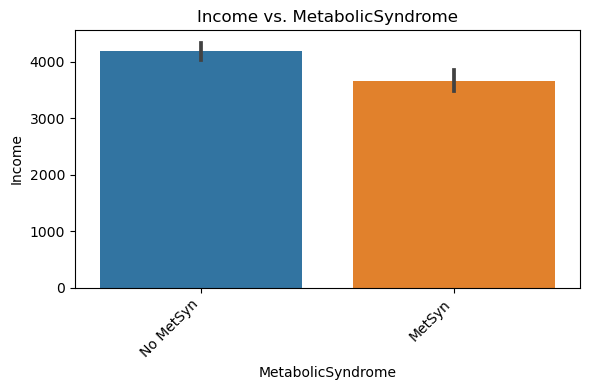

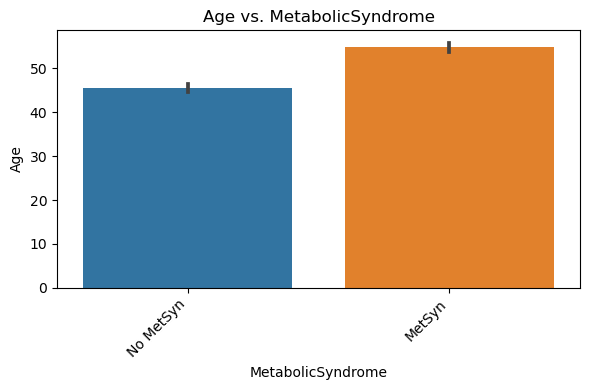

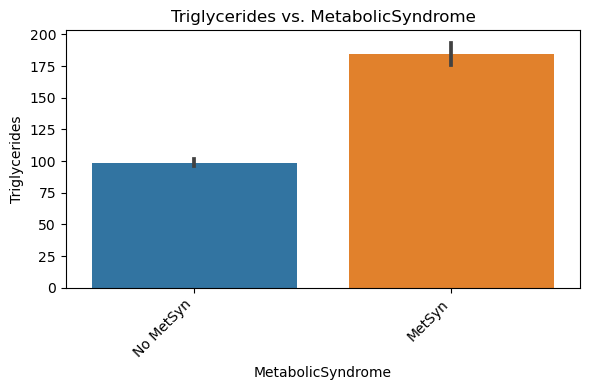

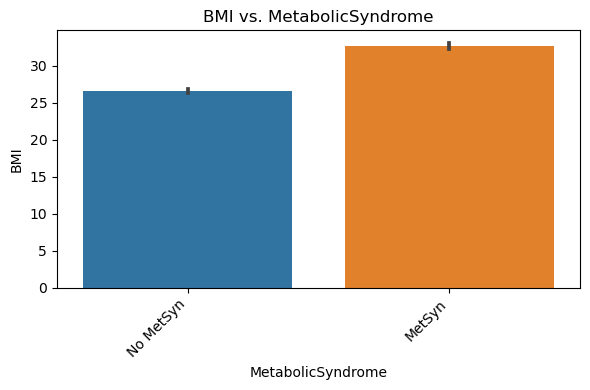

In [12]:
plot_numeric_vs_target(df,'Income','MetabolicSyndrome', target_type='class');
plot_numeric_vs_target(df,'Age','MetabolicSyndrome', target_type='class');
plot_numeric_vs_target(df,'Triglycerides','MetabolicSyndrome', target_type='class');
plot_numeric_vs_target(df,'BMI','MetabolicSyndrome', target_type='class');

---

- from the first glance we can tell from the three examples we've chosen to explore, that higher income, younger people, people with less Triglycerides & people with lower body mass index (BMI) tend to have a lower chance of having metabolic according to this dataset


---

# preprocessing & transforming data

In [13]:
df = df.set_index('seqn')
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [14]:


# Define features and target
X = df.drop(columns = 'MetabolicSyndrome')
y = df['MetabolicSyndrome']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [15]:
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

num_pipe = make_pipeline(impute_median, scaler)


Numeric Columns: Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')


In [16]:
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

# ('title', pipe , cols)

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
        'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
       dtype='object'))

In [17]:
ohe_cols = make_column_selector(dtype_include='object')

print("OneHotEncoder Columns:", ohe_cols)

impute_na = SimpleImputer(strategy='most_frequent')

ohe_encoder = OneHotEncoder(drop = 'first', sparse=False)  

ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

OneHotEncoder Columns: <sklearn.compose._column_transformer.make_column_selector object at 0x0000029A55ABE830>


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(drop='first', sparse=False))])

In [18]:
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

#title, pipe, cols

('categorical',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotencoder', OneHotEncoder(drop='first', sparse=False))]),
 <sklearn.compose._column_transformer.make_column_selector at 0x29a55abe830>)

In [19]:
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000029A55ABE830>)],
                  verbose_feature_names_out=False)

In [20]:
preprocessor.fit(X_train)

X_train_tf = preprocessor.transform(X_train)

X_test_tf = preprocessor.transform(X_test)

X_train_tf.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
seqn,,,,,,,,,,,,,,,,,,,,
63211,-0.176875,1.443579,1.591313,1.815754,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70548,-0.857407,-0.165173,-0.767163,-0.637064,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
64722,-0.914117,-0.165173,-1.465971,-0.561824,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
69237,-0.006742,1.717409,-0.174425,0.687157,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
65286,-1.084250,1.717409,-1.422296,-1.028311,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling: KNN Classification Model

- Disclaimer: 

**the best treatment for metabolic syndrom is a healthy diet and exercise, which is the first treatment when the results are ambiguous but also pointing at a probable metabolic syndrome, hense we here are interested in recallability of the model, to get as much true positives and as less false negatives.**


---

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sampler_pipeline


## KNN default model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.86      0.75      0.80       618
   No MetSyn       0.88      0.93      0.90      1182

    accuracy                           0.87      1800
   macro avg       0.87      0.84      0.85      1800
weighted avg       0.87      0.87      0.87      1800



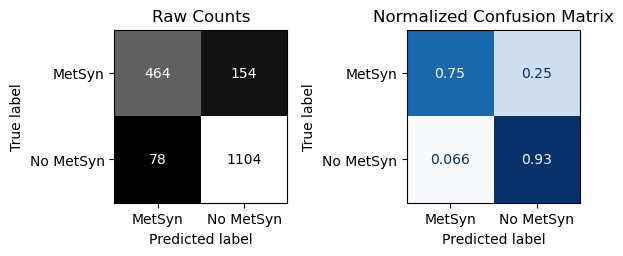


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.71      0.60      0.65       204
   No MetSyn       0.81      0.88      0.84       397

    accuracy                           0.78       601
   macro avg       0.76      0.74      0.75       601
weighted avg       0.78      0.78      0.78       601



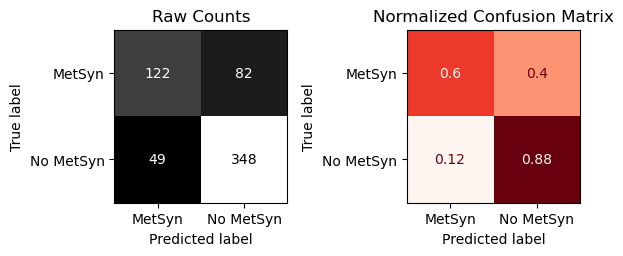

In [22]:

knn = KNeighborsClassifier()


knn_pipe = make_pipeline(preprocessor, knn)

knn_pipe.fit(X_train, y_train)


evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

In [23]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000029A55ABE830>)],
                  verbose_feature_names_out=False)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.75      0.92      0.82       618
   No MetSyn       0.95      0.84      0.89      1182

    accuracy                           0.87      1800
   macro avg       0.85      0.88      0.86      1800
weighted avg       0.88      0.87      0.87      1800



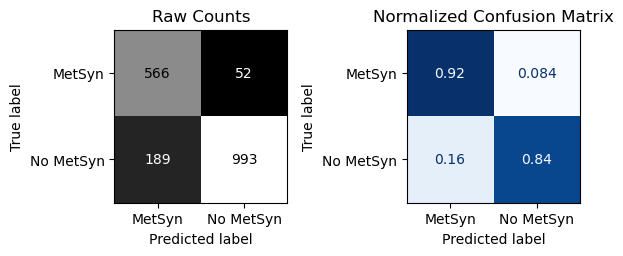


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.63      0.78      0.70       204
   No MetSyn       0.87      0.77      0.82       397

    accuracy                           0.77       601
   macro avg       0.75      0.78      0.76       601
weighted avg       0.79      0.77      0.78       601



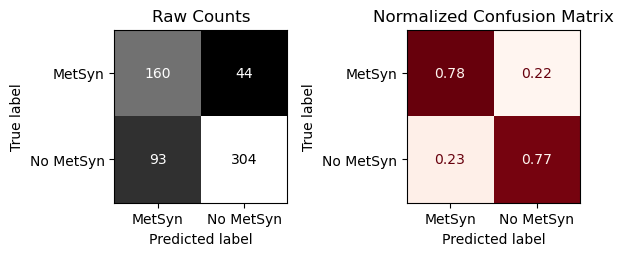

In [24]:
smote = SMOTE(random_state=42)

knn_smote_pipe = make_sampler_pipeline(preprocessor, smote,  knn)

knn_smote_pipe.fit(X_train, y_train)

evaluate_classification(knn_smote_pipe, X_train, y_train, X_test, y_test)

In [25]:
# knn_smote_pipe.get_params()

- the decision is to further work with smote in this situation since it gives better results based on our goal which are:
  - higher recall (higher true positive)
  - this method gives more false positive results that we are willing to accept (from 16% increase to 23%)
  - this method decreases the false negative results from 40% to 22% which is crucial to our goal

- we will have to tune the model more to get better results but this seems as a good start

---

the model has chosen 5 KNeighbours

## KNN tuning

In [26]:
nneighbors_list = list(range(1,33,2))
params_1={'kneighborsclassifier__n_neighbors': nneighbors_list}

gs_knn_smote = GridSearchCV(knn_smote_pipe, params_1, verbose=True, n_jobs=-1, scoring='recall_macro', cv=5 )

In [27]:
# Fit gs on training data
gs_knn_smote.fit(X_train, y_train)
# Obtain best param value for K
gs_knn_smote.best_params_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'kneighborsclassifier__n_neighbors': 29}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.67      0.88      0.76       618
   No MetSyn       0.93      0.78      0.84      1182

    accuracy                           0.81      1800
   macro avg       0.80      0.83      0.80      1800
weighted avg       0.84      0.81      0.82      1800



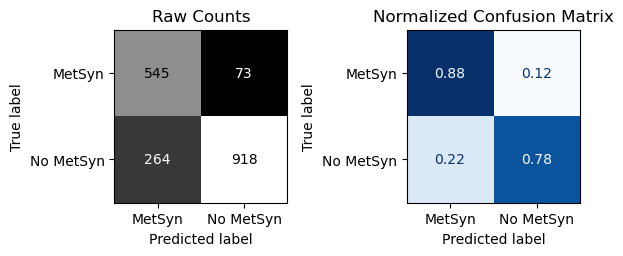


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.66      0.85      0.74       204
   No MetSyn       0.91      0.78      0.84       397

    accuracy                           0.80       601
   macro avg       0.79      0.81      0.79       601
weighted avg       0.83      0.80      0.81       601



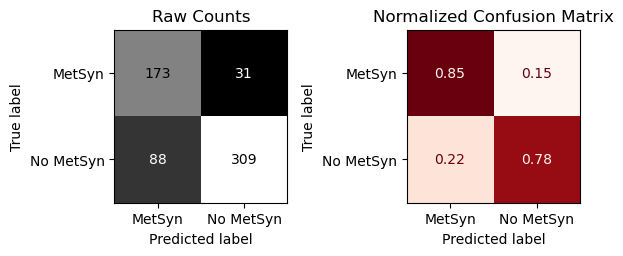

In [28]:
evaluate_classification(gs_knn_smote.best_estimator_, X_train, y_train, X_test, y_test)

**inspecting results on testing data after verifying that the variance is accepted between training and testing data:**

- an increase in MetSyn Recall from 78% to 85%
- a decrease of the false negatives from 22% to 15%
- Macro avrg for Recall has changed from 78% to 81%


---

this model has used 29 Kneighbours

# importances extraction

## imports and function

In [29]:
from sklearn.inspection import permutation_importance
# pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [30]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

##################

## permutated importances

- since our best model parameters were 29 Kneighbours, i will make a new variable with this parameter and extract importances using it

In [31]:
knn_29 = KNeighborsClassifier(n_neighbors=29)

knn29_smote_pipe = make_sampler_pipeline(preprocessor, smote,  knn_29)

knn29_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000029A55ABE830>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE(random_state=42)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=29))])

In [32]:
permutation_importances = permutation_importance(knn29_smote_pipe , X_test, y_test, n_repeats=5, random_state=42)


In [33]:
permutation_importances

{'importances_mean': array([ 0.03427621,  0.01464226,  0.01364393,  0.00332779,  0.00698835,
         0.02462562,  0.01464226,  0.00698835,  0.00133111, -0.00066556,
         0.04392679,  0.03527454,  0.05657238]),
 'importances_std': array([0.01039634, 0.00322641, 0.00617213, 0.00622572, 0.00570597,
        0.00685233, 0.00660547, 0.00486813, 0.0022074 , 0.00653806,
        0.00670531, 0.00876668, 0.00729082]),
 'importances': array([[ 0.04326123,  0.04326123,  0.03327787,  0.01497504,  0.03660566],
        [ 0.01164725,  0.01663894,  0.01663894,  0.00998336,  0.01830283],
        [ 0.00998336,  0.00499168,  0.02329451,  0.01663894,  0.01331115],
        [ 0.        , -0.00332779,  0.00332779,  0.01497504,  0.00166389],
        [ 0.00166389,  0.01164725,  0.01497504,  0.        ,  0.00665557],
        [ 0.01996672,  0.02163062,  0.02163062,  0.03826955,  0.02163062],
        [ 0.01663894,  0.00665557,  0.00831947,  0.01663894,  0.0249584 ],
        [ 0.00166389,  0.01497504,  0.003327

In [34]:
permutation_importances = pd.Series(permutation_importances['importances_mean'],index=X_test.columns,
                           name = 'permutation importance')

In [35]:
permutation_importances = permutation_importances.sort_values(ascending=False)

permutation_importances

Triglycerides    0.056572
BloodGlucose     0.043927
HDL              0.035275
Age              0.034276
WaistCirc        0.024626
Sex              0.014642
BMI              0.014642
Marital          0.013644
Race             0.006988
Albuminuria      0.006988
Income           0.003328
UrAlbCr          0.001331
UricAcid        -0.000666
Name: permutation importance, dtype: float64

<Axes: title={'center': 'Top 15 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

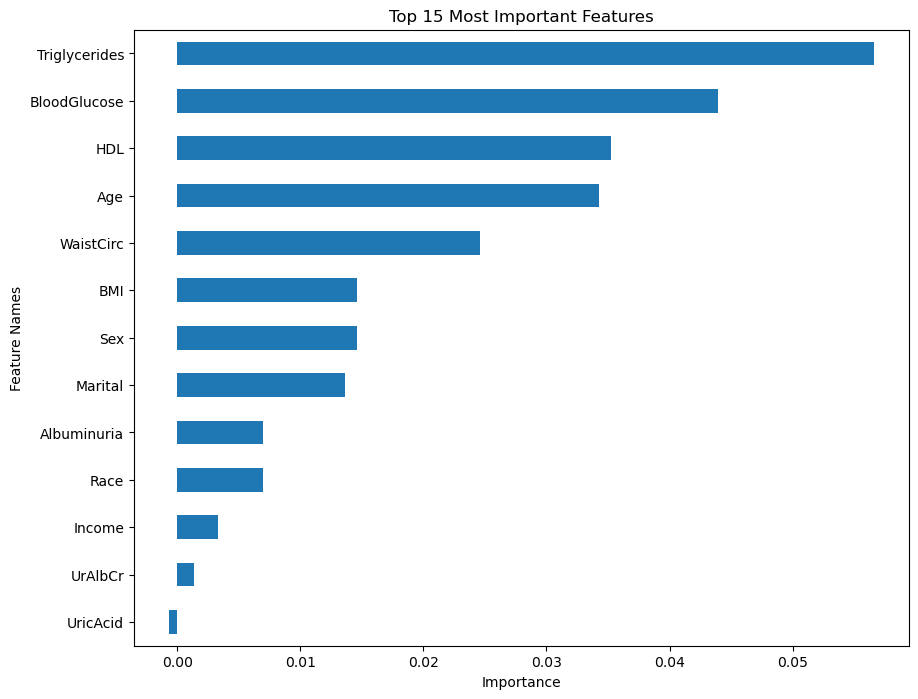

In [36]:
n = 15
plot_importance_color_ax(permutation_importances, top_n=n,
                         figsize=(10,8))

### permutation from transformed(processed) data

In [37]:
permutation_importances_tf = permutation_importance(knn_29 , X_test_tf, y_test, n_repeats=5, random_state=42)
permutation_importances_tf


{'importances_mean': array([ 0.03427621,  0.00332779,  0.02462562,  0.01464226,  0.00698835,
         0.00133111, -0.00066556,  0.04392679,  0.03527454,  0.05657238,
         0.01464226,  0.00998336,  0.00066556,  0.00499168,  0.00166389,
         0.0093178 ,  0.00099834, -0.00033278,  0.        ,  0.00831947]),
 'importances_std': array([0.01039634, 0.00622572, 0.00685233, 0.00660547, 0.00486813,
        0.0022074 , 0.00653806, 0.00670531, 0.00876668, 0.00729082,
        0.00322641, 0.00278423, 0.00169685, 0.00148823, 0.00148823,
        0.00342617, 0.00225701, 0.00124514, 0.        , 0.00526169]),
 'importances': array([[ 0.04326123,  0.04326123,  0.03327787,  0.01497504,  0.03660566],
        [ 0.        , -0.00332779,  0.00332779,  0.01497504,  0.00166389],
        [ 0.01996672,  0.02163062,  0.02163062,  0.03826955,  0.02163062],
        [ 0.01663894,  0.00665557,  0.00831947,  0.01663894,  0.0249584 ],
        [ 0.00166389,  0.01497504,  0.00332779,  0.00998336,  0.00499168],
   

In [38]:
permutation_importances_tf = pd.Series(permutation_importances_tf['importances_mean'],index=X_test_tf.columns,
                           name = 'permutation importance')

<Axes: title={'center': 'Top 15 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

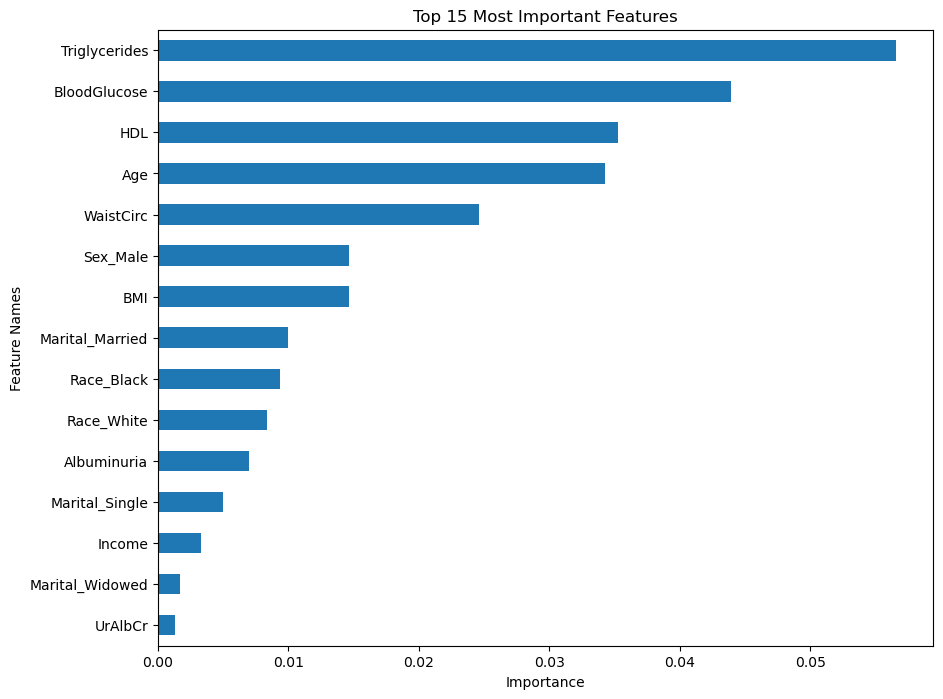

In [39]:
plot_importance_color_ax(permutation_importances_tf, top_n=n,
                         figsize=(10,8))

# Visualizing important features for the model we've chosen to work with

- lets concate our processed df in order to work with what singled out categories

---

In [40]:
plot_df_train = pd.concat([X_train_tf, y_train],axis=1)
plot_df_test = pd.concat([X_test_tf, y_test],axis=1)
plot_df = pd.concat([plot_df_train, plot_df_test])
plot_df.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White,MetabolicSyndrome
seqn,,,,,,,,,,,,,,,,,,,,,
63211,-0.176875,1.443579,1.591313,1.815754,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MetSyn
70548,-0.857407,-0.165173,-0.767163,-0.637064,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No MetSyn
64722,-0.914117,-0.165173,-1.465971,-0.561824,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No MetSyn
69237,-0.006742,1.717409,-0.174425,0.687157,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No MetSyn
65286,-1.084250,1.717409,-1.422296,-1.028311,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No MetSyn


In [41]:
plot_df['MetabolicSyndrome_num'] = plot_df['MetabolicSyndrome'].replace({'MetSyn': 1, 'No MetSyn': 0})
plot_df.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White,MetabolicSyndrome,MetabolicSyndrome_num
seqn,,,,,,,,,,,,,,,,,,,,,,
63211,-0.176875,1.443579,1.591313,1.815754,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MetSyn,1
70548,-0.857407,-0.165173,-0.767163,-0.637064,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No MetSyn,0
64722,-0.914117,-0.165173,-1.465971,-0.561824,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No MetSyn,0
69237,-0.006742,1.717409,-0.174425,0.687157,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No MetSyn,0
65286,-1.084250,1.717409,-1.422296,-1.028311,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No MetSyn,0


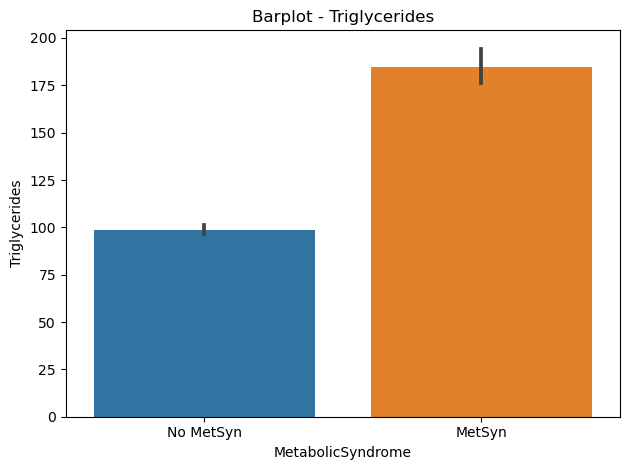

<Figure size 640x480 with 0 Axes>

In [42]:
sns.barplot(data=df, x='MetabolicSyndrome',y='Triglycerides');


plt.title("Barplot - Triglycerides")
plt.xlabel("MetabolicSyndrome")
plt.ylabel("Triglycerides")
plt.tight_layout()
plt.show()
plt.savefig('MSvsTrig.png')

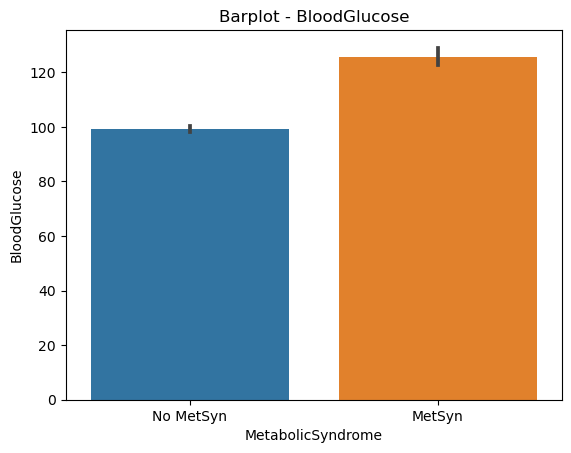

<Figure size 640x480 with 0 Axes>

In [43]:
sns.barplot(data=df, x='MetabolicSyndrome',y='BloodGlucose');

plt.title("Barplot - BloodGlucose")
plt.xlabel("MetabolicSyndrome")
plt.ylabel("BloodGlucose")
plt.show()
plt.tight_layout()
plt.savefig('MSvsBloodG.png')

# Second - feature select - dimension reduction - tunning

In [44]:
X_train_tf.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
seqn,,,,,,,,,,,,,,,,,,,,
63211,-0.176875,1.443579,1.591313,1.815754,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70548,-0.857407,-0.165173,-0.767163,-0.637064,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
64722,-0.914117,-0.165173,-1.465971,-0.561824,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
69237,-0.006742,1.717409,-0.174425,0.687157,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
65286,-1.084250,1.717409,-1.422296,-1.028311,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
y_train.value_counts()

No MetSyn    1182
MetSyn        618
Name: MetabolicSyndrome, dtype: int64

## applying smote

In [46]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_sm,y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()

MetSyn       1182
No MetSyn    1182
Name: MetabolicSyndrome, dtype: int64

## correlation filtering

In [47]:
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif
# from sklearn.feature_selection import f_regression

# Instantiate the selector, indicate theshold for r, also include the appropriate scoring metric for the task
selector = SelectNonCollinear(correlation_threshold = 0.75, scoring = f_classif)

# Fit on the training data, use .values (.vlues cause arrays)
selector.fit(X_train_sm.values, y_train_sm.values)

# Define a mask for filtering
non_collinear = selector.get_support()

# non_collinear[:-1]

In [48]:
# Make the T/F a series with the column names as the index
non_collinear_series = pd.Series(selector.get_support(), index=X_train_sm.columns)

In [49]:
non_collinear_series.shape

(20,)

In [50]:
X_train_sm

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
0,-0.176875,1.443579,1.591313,1.815754,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000
1,-0.857407,-0.165173,-0.767163,-0.637064,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,1.000000,0.000000,1.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.000000
2,-0.914117,-0.165173,-1.465971,-0.561824,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.000000
3,-0.006742,1.717409,-0.174425,0.687157,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,0.000000,1.000000,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.000000
4,-1.084250,1.717409,-1.422296,-1.028311,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,1.224528,-0.418448,1.206113,0.498553,-0.366397,-0.146900,-0.685204,5.488377,-1.057466,0.978783,1.000000,0.725945,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000
2360,0.944351,-0.678604,0.664643,0.900578,-0.366397,-0.139967,-0.638316,0.647467,-0.045857,0.131733,0.000000,1.000000,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000
2361,-0.158718,1.109499,1.473120,0.772888,-0.366397,-0.150435,2.402109,0.288724,-0.413931,0.489989,1.000000,0.651420,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000
2362,-0.176875,-1.089350,0.265114,0.074374,-0.366397,-0.135910,-0.139466,-0.069979,-1.327559,2.116328,0.829742,0.000000,0.0,0.829742,0.0,0.0,0.000000,0.0,0.0,1.000000


In [51]:
# Filter training data
training_data_to_keep = X_train_sm.values[:, non_collinear]


# Filter column names
columns = np.array(X_train_sm.columns)[non_collinear]

# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = X_test_tf.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)

In [52]:
X_train_no_corr.head()

,Age,Income,WaistCirc,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
0,-0.176875,1.443579,1.591313,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.857407,-0.165173,-0.767163,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.914117,-0.165173,-1.465971,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.006742,1.717409,-0.174425,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.084250,1.717409,-1.422296,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# X_test_no_corr.head()

In [54]:
X_train_no_corr.shape

(2364, 19)

In [55]:
X_train_tf.shape

(1800, 20)

In [56]:
diff = set(X_train_tf.columns) - set(X_train_no_corr.columns)
diff

{'BMI'}

---

this filtering has filtered out Body Mass Index, which was the 7th most permutated important feature in our previous tuned model

---

## PCA

In [57]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_no_corr)
X_test_pca = pca.transform(X_test_no_corr)

pca.explained_variance_ratio_.sum()

0.9596632129377145

# pseudo preprocessor

In [58]:
X_train_pca.isna().sum().sum()

0

In [59]:
num_cols = X_train_pca.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

impute_median = SimpleImputer(strategy= 'median')

num_pipe = make_pipeline(impute_median)

num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

preprocessor_pseudo = ColumnTransformer([num_tuple], verbose_feature_names_out=False)
preprocessor_pseudo

Numeric Columns: Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11'],
      dtype='object')


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11'],
      dtype='object'))],
                  verbose_feature_names_out=False)

# NEW KNN MODEL USING filtered PCAs

In [60]:
from sklearn.metrics import make_scorer
# Define a custom scoring function for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Create a scorer object using the custom scoring function
specificity_scorer = make_scorer(specificity_score)


In [61]:
knn_new = KNeighborsClassifier()

knn_pseudo = make_pipeline(preprocessor_pseudo, knn_new)



nneighbors_list = list(range(1,33,2))
params_2={'kneighborsclassifier__n_neighbors': nneighbors_list}

gs_knn_pseudo = GridSearchCV(knn_pseudo, params_2, verbose=True, n_jobs=-1, scoring=specificity_scorer, cv=5 )

# Fit gs on training data
gs_knn_pseudo.fit(X_train_pca, y_train_sm)
# Obtain best param value for K
gs_knn_pseudo.best_params_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'kneighborsclassifier__n_neighbors': 1}

In [62]:
nneighbors_list = list(range(1,33,2))
nneighbors_list

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

# Model 1,2,3 comparison

---
# Comparing 
- knn_smote_pipe : Model 1
- gs_knn_pseudo : Model 2
- knn_psuedo31 : Model 3

---

## Model 1

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.75      0.92      0.82       618
   No MetSyn       0.95      0.84      0.89      1182

    accuracy                           0.87      1800
   macro avg       0.85      0.88      0.86      1800
weighted avg       0.88      0.87      0.87      1800



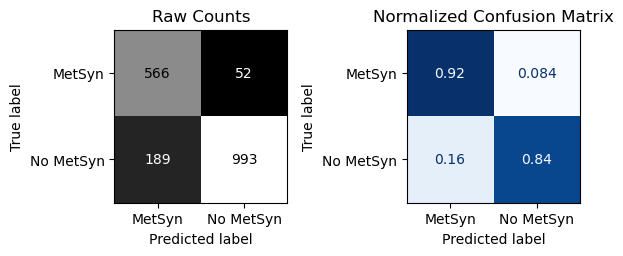


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.63      0.78      0.70       204
   No MetSyn       0.87      0.77      0.82       397

    accuracy                           0.77       601
   macro avg       0.75      0.78      0.76       601
weighted avg       0.79      0.77      0.78       601



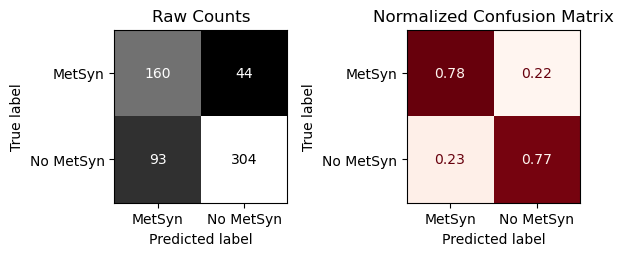

In [63]:
evaluate_classification(knn_smote_pipe, X_train, y_train, X_test, y_test)

## Model 2

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       1.00      1.00      1.00      1182
   No MetSyn       1.00      1.00      1.00      1182

    accuracy                           1.00      2364
   macro avg       1.00      1.00      1.00      2364
weighted avg       1.00      1.00      1.00      2364



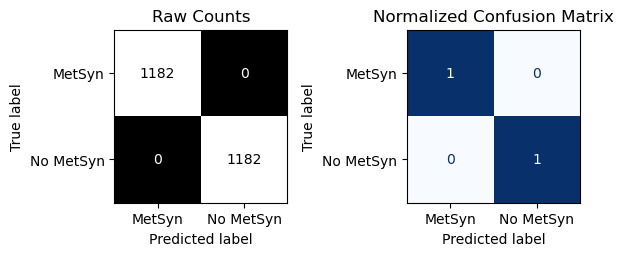


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.66      0.65      0.65       204
   No MetSyn       0.82      0.83      0.82       397

    accuracy                           0.77       601
   macro avg       0.74      0.74      0.74       601
weighted avg       0.77      0.77      0.77       601



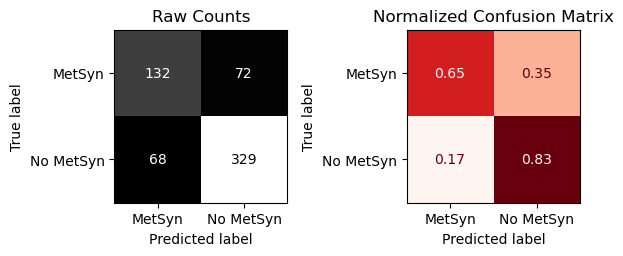

In [64]:
evaluate_classification(gs_knn_pseudo.best_estimator_, X_train_pca, y_train_sm, X_test_pca, y_test)

## Model 3

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.81      0.89      0.85      1182
   No MetSyn       0.88      0.80      0.84      1182

    accuracy                           0.84      2364
   macro avg       0.85      0.84      0.84      2364
weighted avg       0.85      0.84      0.84      2364



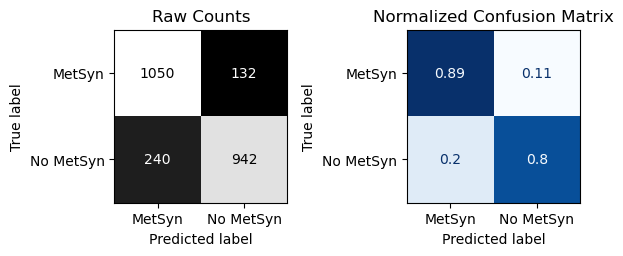


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.67      0.84      0.75       204
   No MetSyn       0.90      0.79      0.84       397

    accuracy                           0.81       601
   macro avg       0.79      0.81      0.79       601
weighted avg       0.83      0.81      0.81       601



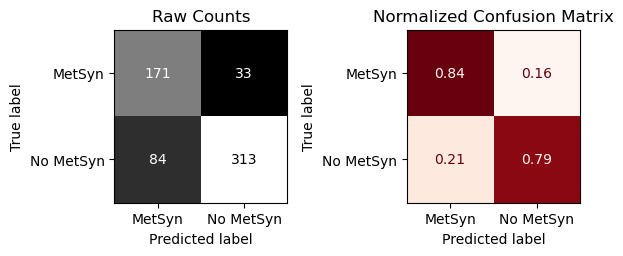

In [65]:
knn_new31 = KNeighborsClassifier(n_neighbors=31)

knn_psuedo31 = make_pipeline(preprocessor_pseudo, knn_new31)

knn_psuedo31.fit(X_train_pca, y_train_sm)

evaluate_classification(knn_psuedo31,X_train_pca, y_train_sm, X_test_pca, y_test)

# permutation comparison [ normalizing other variables with the previous model (features\Kneighbours)]

## normalized

In [66]:
knn_new29 = KNeighborsClassifier(n_neighbors=29)

knn_new29.fit(X_train_no_corr, y_train_sm)

KNeighborsClassifier(n_neighbors=29)

<Axes: title={'center': 'Top 15 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

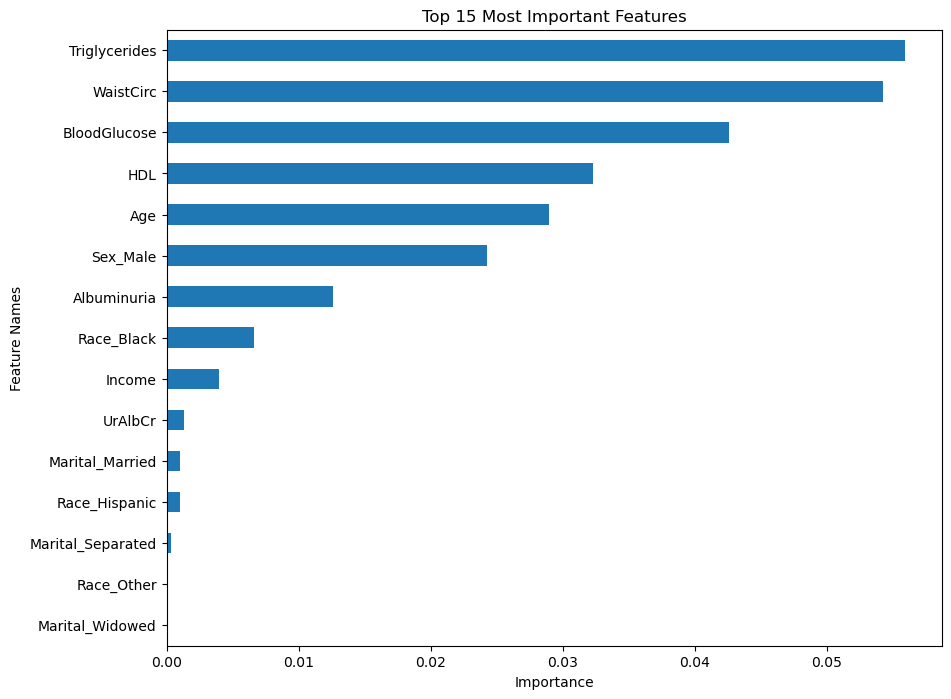

In [67]:
# X_test_pca.head()

permutation_importances_new = permutation_importance(knn_new29 , X_test_no_corr, y_test, n_repeats=5, random_state=42)
permutation_importances_new



permutation_importances_new = pd.Series(permutation_importances_new['importances_mean'],index=X_test_no_corr.columns,
                           name = 'permutation importance')



plot_importance_color_ax(permutation_importances_new, top_n=n,
                         figsize=(10,8))

## 31 neighbours permutation importance

In [68]:
knn_new_31 = KNeighborsClassifier(n_neighbors=31)

knn_new_31.fit(X_train_no_corr, y_train_sm)

KNeighborsClassifier(n_neighbors=31)

<Axes: title={'center': 'Top 15 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

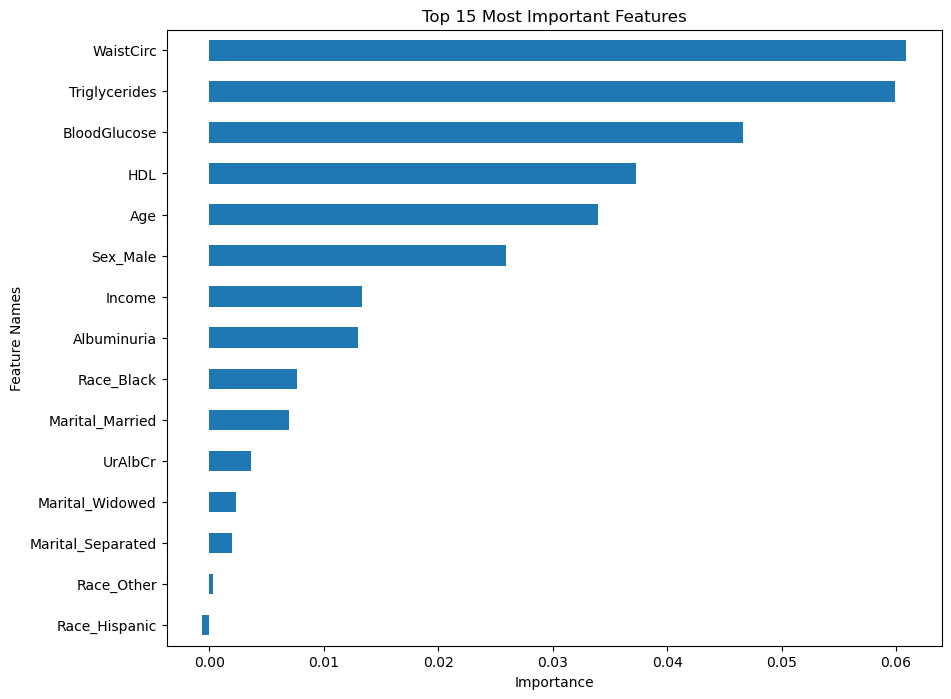

In [69]:
# X_test_pca.head()

permutation_importances_new = permutation_importance(knn_new_31 , X_test_no_corr, y_test, n_repeats=5, random_state=42)
permutation_importances_new



permutation_importances_new = pd.Series(permutation_importances_new['importances_mean'],index=X_test_no_corr.columns,
                           name = 'permutation importance')



plot_importance_color_ax(permutation_importances_new, top_n=n,
                         figsize=(10,8))

# Kmean cluster extraction

## visualizing our data

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

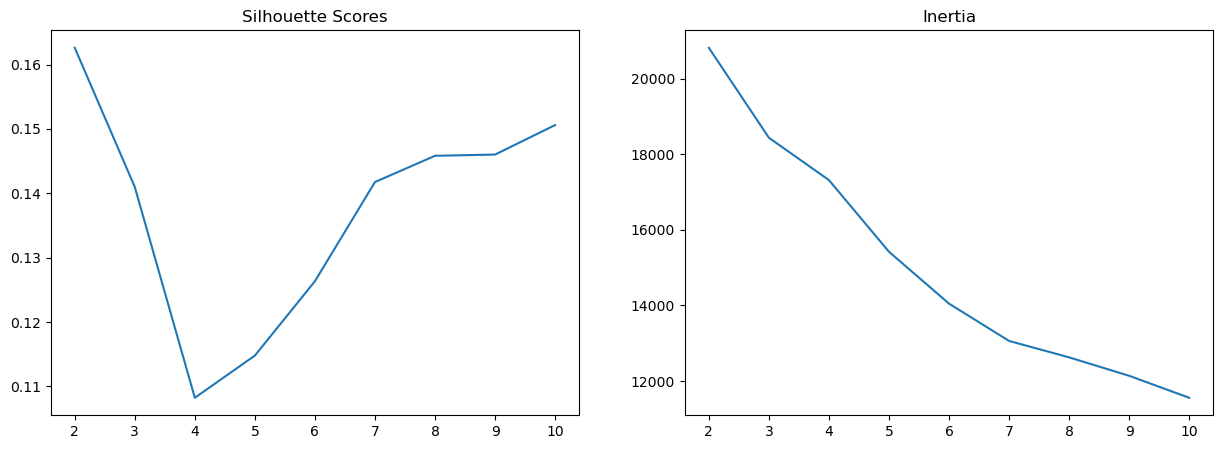

In [71]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
  kmeans.fit(X_train_pca)
  sils.append(silhouette_score(X_train_pca, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);


#######################




In [72]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

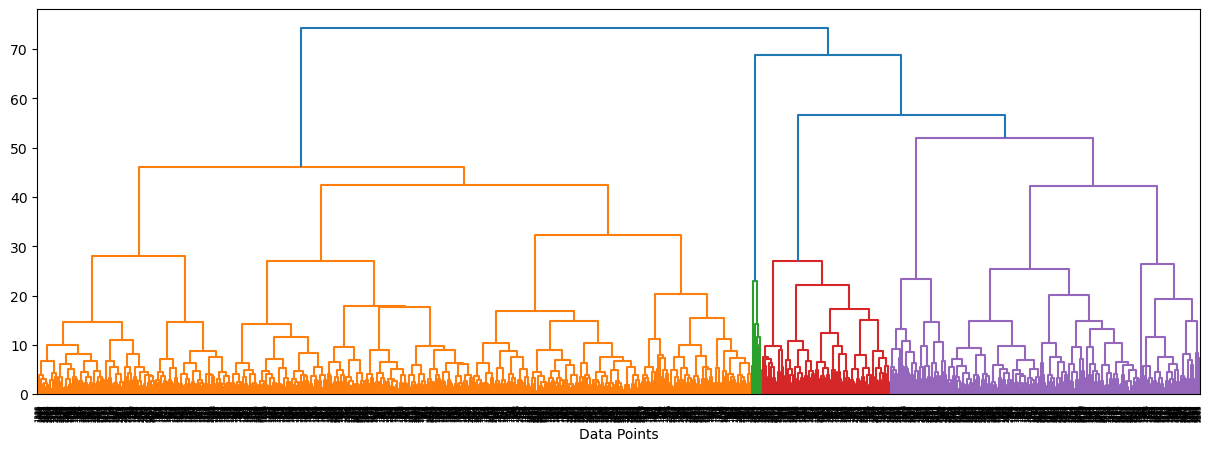

In [73]:
# Visualize Dendogram
plt.figure(figsize = (15, 5))
sch.dendrogram(sch.linkage(X_train_pca, method = 'ward'))
plt.xlabel('Data Points');

--- 

i will be choosing 3 clusters based on the previous graphs

---

In [74]:
kmeans = KMeans(n_clusters=3, n_init= 'auto', random_state=42)
kmeans.fit(X_train_pca)
# Add the clusters as a column in the dataframe
X_train_pca_c = X_train_pca.copy()

X_train_pca_c['cluster'] = kmeans.labels_
X_train_pca_c.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,cluster
0,0.088726,-0.740082,0.849100,-0.569133,1.580633,-0.770970,-1.886522,0.571639,-0.405472,-0.432810,0.159633,0.142409,2
1,-1.573625,0.836514,-0.157162,0.027571,-0.274172,-0.311757,1.233311,1.122462,-0.717675,-0.196636,-0.226963,-0.701179,0
2,-1.934193,0.360833,0.010778,1.319395,0.696668,-0.386982,-0.131329,-0.876173,0.762220,-0.183655,-0.540806,0.320350,0
3,-1.491577,0.117296,0.166801,-0.349233,1.756133,0.012423,-1.497328,-0.582599,0.207907,0.469556,-0.386886,0.110452,0
4,-0.314480,-0.907830,-2.034644,0.140587,2.446431,1.810787,1.013692,0.674869,-0.744738,0.242715,-0.494557,-0.200449,2


In [75]:
cluster_groups = X_train_pca_c.groupby('cluster', as_index=False).mean()
cluster_groups


,cluster,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11
0,0,-1.244496,0.399249,0.065655,0.140879,0.097674,0.015095,-0.016817,0.067417,0.007795,-0.014674,0.010676,0.016326
1,1,2.366761,1.674393,0.104959,0.138839,0.013121,-0.079269,0.057822,-0.682230,-0.690504,-0.055705,0.001917,0.000095
2,2,0.618220,-0.881094,-0.097090,-0.184099,-0.104315,0.006686,0.001105,0.121938,0.185688,0.030747,-0.011538,-0.016847


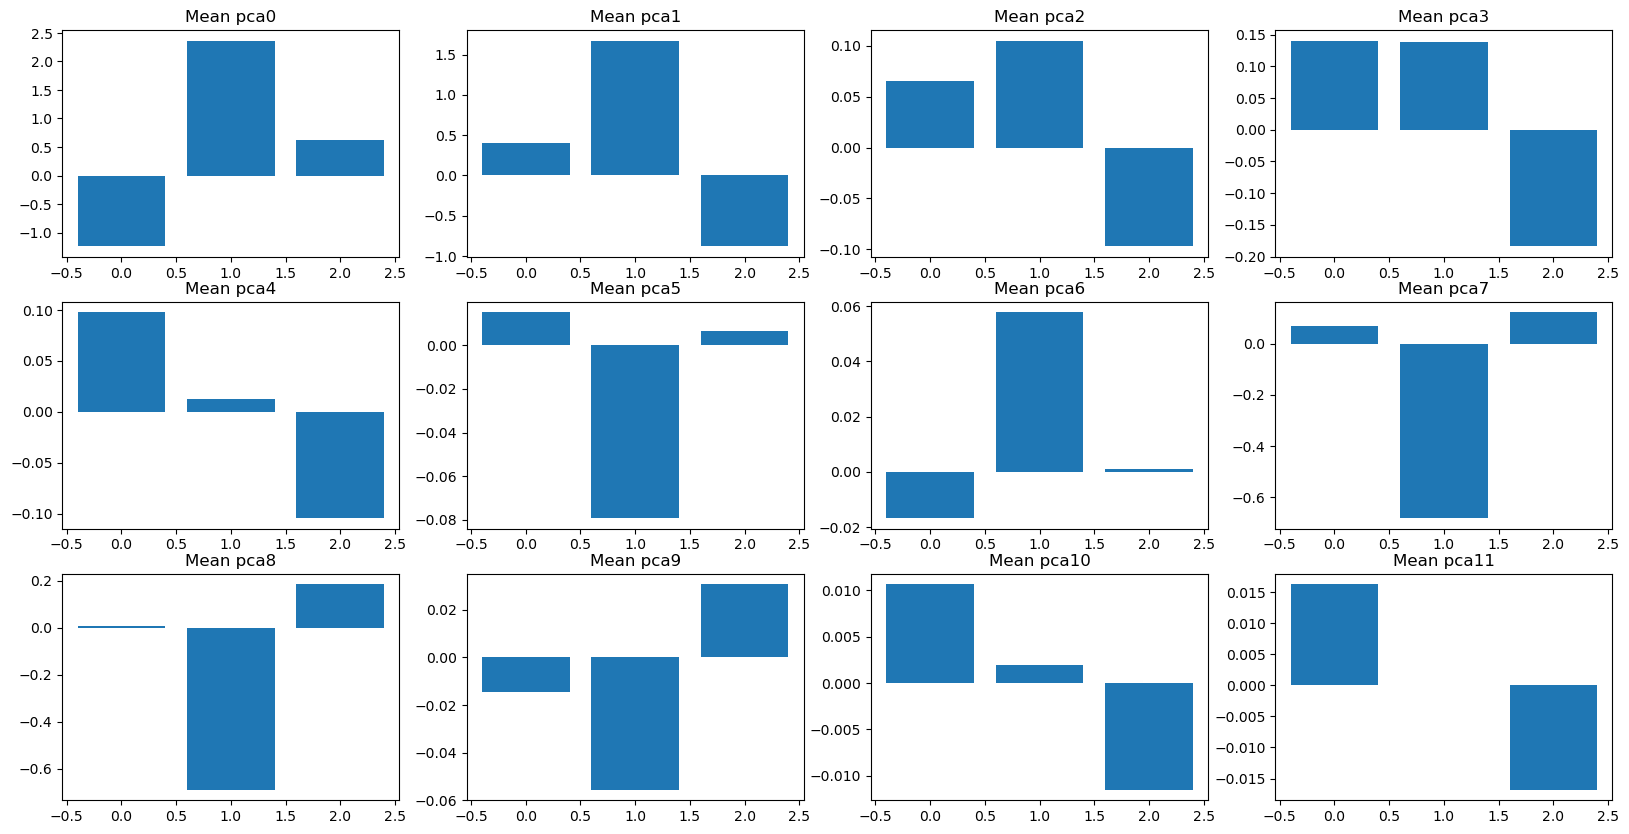

In [76]:
# Visualize means 
fig, axes = plt.subplots(3,4, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')



# trying my model with clusters included [ MODEL 4 ]

In [77]:
X_train_pca_c

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,cluster
0,0.088726,-0.740082,0.849100,-0.569133,1.580633,-0.770970,-1.886522,0.571639,-0.405472,-0.432810,0.159633,0.142409,2
1,-1.573625,0.836514,-0.157162,0.027571,-0.274172,-0.311757,1.233311,1.122462,-0.717675,-0.196636,-0.226963,-0.701179,0
2,-1.934193,0.360833,0.010778,1.319395,0.696668,-0.386982,-0.131329,-0.876173,0.762220,-0.183655,-0.540806,0.320350,0
3,-1.491577,0.117296,0.166801,-0.349233,1.756133,0.012423,-1.497328,-0.582599,0.207907,0.469556,-0.386886,0.110452,0
4,-0.314480,-0.907830,-2.034644,0.140587,2.446431,1.810787,1.013692,0.674869,-0.744738,0.242715,-0.494557,-0.200449,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,2.798689,-1.455265,4.052097,0.391890,1.465060,-1.921025,0.784889,0.839184,0.550551,-0.687337,0.394545,-0.375821,2
2360,0.109669,-0.116564,1.390079,-0.015370,-0.392411,0.011385,-0.498016,0.233890,0.275354,0.362914,-0.750561,0.255733,2
2361,1.330915,-1.396494,-1.359311,-1.678159,-0.035955,-0.370301,0.593414,0.633134,-0.279870,-0.401623,0.311853,0.085053,2
2362,0.874956,-1.523372,-0.153077,1.686997,0.020719,1.054235,-0.374881,0.112900,0.137305,0.178681,0.851375,-0.329720,2


In [78]:
X_test_pca_c = X_test_pca.copy()

X_test_pca_c

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11
0,-0.063127,-1.083429,-1.144118,1.139529,-0.244731,-0.209029,0.258945,0.068897,0.136203,-1.060834,-0.050841,-0.118458
1,0.234610,-0.255243,0.885408,-0.709289,-0.616852,0.659788,-0.956073,0.164376,0.187561,0.208086,0.805782,0.319109
2,-0.079313,2.633067,0.754242,-1.520480,-1.177480,0.927214,0.299300,0.848306,-2.479708,0.343343,-0.317599,-0.080332
3,0.002525,-0.660477,-1.215198,-0.840416,0.477608,-0.413796,0.108457,-0.079113,0.034133,1.442396,0.427653,-0.345482
4,3.823900,-0.651720,2.552936,1.730086,2.246418,0.227338,0.481905,-0.056221,-1.223513,-0.075278,-0.645945,-0.519525
...,...,...,...,...,...,...,...,...,...,...,...,...
596,1.411216,1.116496,0.542727,-0.441570,-1.024419,0.594322,0.369210,-1.699430,-0.126568,-0.065927,0.987155,-0.271149
597,-0.397806,-0.092782,-0.329974,-1.613204,0.843500,-0.570355,0.112188,-0.118186,0.205909,0.597863,-0.467857,-0.360219
598,-1.488539,0.118132,-0.144361,1.617585,0.252537,-0.179946,0.214819,0.069459,-0.023836,0.441735,0.427701,0.275223
599,-0.473602,-0.175986,0.609971,0.671932,-0.051063,0.585888,-0.426736,-0.357736,0.529230,0.098053,-0.633780,0.336615


In [79]:
X_test_pca_c['cluster'] = kmeans.predict(X_test_pca)

In [80]:
X_test_pca_c

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,cluster
0,-0.063127,-1.083429,-1.144118,1.139529,-0.244731,-0.209029,0.258945,0.068897,0.136203,-1.060834,-0.050841,-0.118458,2
1,0.234610,-0.255243,0.885408,-0.709289,-0.616852,0.659788,-0.956073,0.164376,0.187561,0.208086,0.805782,0.319109,2
2,-0.079313,2.633067,0.754242,-1.520480,-1.177480,0.927214,0.299300,0.848306,-2.479708,0.343343,-0.317599,-0.080332,1
3,0.002525,-0.660477,-1.215198,-0.840416,0.477608,-0.413796,0.108457,-0.079113,0.034133,1.442396,0.427653,-0.345482,2
4,3.823900,-0.651720,2.552936,1.730086,2.246418,0.227338,0.481905,-0.056221,-1.223513,-0.075278,-0.645945,-0.519525,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,1.411216,1.116496,0.542727,-0.441570,-1.024419,0.594322,0.369210,-1.699430,-0.126568,-0.065927,0.987155,-0.271149,1
597,-0.397806,-0.092782,-0.329974,-1.613204,0.843500,-0.570355,0.112188,-0.118186,0.205909,0.597863,-0.467857,-0.360219,2
598,-1.488539,0.118132,-0.144361,1.617585,0.252537,-0.179946,0.214819,0.069459,-0.023836,0.441735,0.427701,0.275223,0
599,-0.473602,-0.175986,0.609971,0.671932,-0.051063,0.585888,-0.426736,-0.357736,0.529230,0.098053,-0.633780,0.336615,0


In [81]:
num_cols = X_train_pca_c.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

impute_median = SimpleImputer(strategy= 'median')

num_pipe = make_pipeline(impute_median)

num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

preprocessor_pseudo_c = ColumnTransformer([num_tuple], verbose_feature_names_out=False)
preprocessor_pseudo_c

Numeric Columns: Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11', 'cluster'],
      dtype='object')


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11', 'cluster'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [82]:
knn_new31_c = KNeighborsClassifier(n_neighbors=31)

knn_psuedo31_c = make_pipeline(preprocessor_pseudo_c, knn_new31_c)

knn_psuedo31_c.fit(X_train_pca_c, y_train_sm)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11', 'cluster'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=31))])

In [83]:
X_train_pca_c.head(2)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,cluster
0,0.088726,-0.740082,0.849100,-0.569133,1.580633,-0.770970,-1.886522,0.571639,-0.405472,-0.432810,0.159633,0.142409,2
1,-1.573625,0.836514,-0.157162,0.027571,-0.274172,-0.311757,1.233311,1.122462,-0.717675,-0.196636,-0.226963,-0.701179,0


In [84]:
X_test_pca_c

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,cluster
0,-0.063127,-1.083429,-1.144118,1.139529,-0.244731,-0.209029,0.258945,0.068897,0.136203,-1.060834,-0.050841,-0.118458,2
1,0.234610,-0.255243,0.885408,-0.709289,-0.616852,0.659788,-0.956073,0.164376,0.187561,0.208086,0.805782,0.319109,2
2,-0.079313,2.633067,0.754242,-1.520480,-1.177480,0.927214,0.299300,0.848306,-2.479708,0.343343,-0.317599,-0.080332,1
3,0.002525,-0.660477,-1.215198,-0.840416,0.477608,-0.413796,0.108457,-0.079113,0.034133,1.442396,0.427653,-0.345482,2
4,3.823900,-0.651720,2.552936,1.730086,2.246418,0.227338,0.481905,-0.056221,-1.223513,-0.075278,-0.645945,-0.519525,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,1.411216,1.116496,0.542727,-0.441570,-1.024419,0.594322,0.369210,-1.699430,-0.126568,-0.065927,0.987155,-0.271149,1
597,-0.397806,-0.092782,-0.329974,-1.613204,0.843500,-0.570355,0.112188,-0.118186,0.205909,0.597863,-0.467857,-0.360219,2
598,-1.488539,0.118132,-0.144361,1.617585,0.252537,-0.179946,0.214819,0.069459,-0.023836,0.441735,0.427701,0.275223,0
599,-0.473602,-0.175986,0.609971,0.671932,-0.051063,0.585888,-0.426736,-0.357736,0.529230,0.098053,-0.633780,0.336615,0


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.80      0.90      0.85      1182
   No MetSyn       0.89      0.77      0.82      1182

    accuracy                           0.84      2364
   macro avg       0.84      0.84      0.83      2364
weighted avg       0.84      0.84      0.83      2364



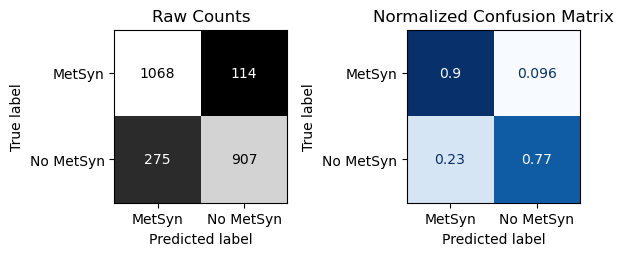


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.63      0.88      0.73       204
   No MetSyn       0.92      0.73      0.81       397

    accuracy                           0.78       601
   macro avg       0.77      0.80      0.77       601
weighted avg       0.82      0.78      0.79       601



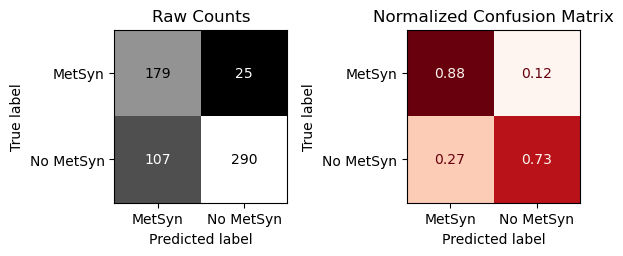

In [85]:
evaluate_classification(knn_psuedo31_c,X_train_pca_c,  y_train_sm, X_test_pca_c, y_test)

In [86]:
permutation_importances_c = permutation_importance(knn_psuedo31_c , X_test_pca_c, y_test, n_repeats=5, random_state=42)
permutation_importances_c


print(type(permutation_importances_c))
permutation_importances_c

<class 'sklearn.utils._bunch.Bunch'>


{'importances_mean': array([ 0.11747088, -0.00332779,  0.04126456,  0.00732113,  0.00965058,
         0.00831947,  0.00865225,  0.0109817 ,  0.00965058,  0.01364393,
         0.00565724,  0.00898502,  0.01963394]),
 'importances_std': array([0.01001658, 0.00923423, 0.00937704, 0.00342617, 0.00776167,
        0.00407569, 0.00486813, 0.01193372, 0.00530362, 0.00783268,
        0.00733624, 0.00225701, 0.00783268]),
 'importances': array([[ 0.10648918,  0.10981697,  0.11480865,  0.12146423,  0.13477537],
        [-0.00499168,  0.01331115, -0.01331115, -0.00166389, -0.00998336],
        [ 0.03826955,  0.02995008,  0.05657238,  0.03494176,  0.04658902],
        [ 0.00166389,  0.00665557,  0.00998336,  0.01164725,  0.00665557],
        [-0.00332779,  0.01164725,  0.01331115,  0.00665557,  0.01996672],
        [ 0.00499168,  0.00831947,  0.01497504,  0.00332779,  0.00998336],
        [ 0.01663894,  0.00831947,  0.00998336,  0.00665557,  0.00166389],
        [ 0.01497504,  0.03161398,  0.008319

In [87]:
permutation_importances_c['importances_mean']

array([ 0.11747088, -0.00332779,  0.04126456,  0.00732113,  0.00965058,
        0.00831947,  0.00865225,  0.0109817 ,  0.00965058,  0.01364393,
        0.00565724,  0.00898502,  0.01963394])

In [88]:
permutation_importances_c = pd.Series(permutation_importances_c['importances_mean'],index=X_test_pca_c.columns,
                           name = 'permutation importance')

permutation_importances_c



pca0       0.117471
pca1      -0.003328
pca2       0.041265
pca3       0.007321
pca4       0.009651
pca5       0.008319
pca6       0.008652
pca7       0.010982
pca8       0.009651
pca9       0.013644
pca10      0.005657
pca11      0.008985
cluster    0.019634
Name: permutation importance, dtype: float64

<Axes: title={'center': 'Top 15 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

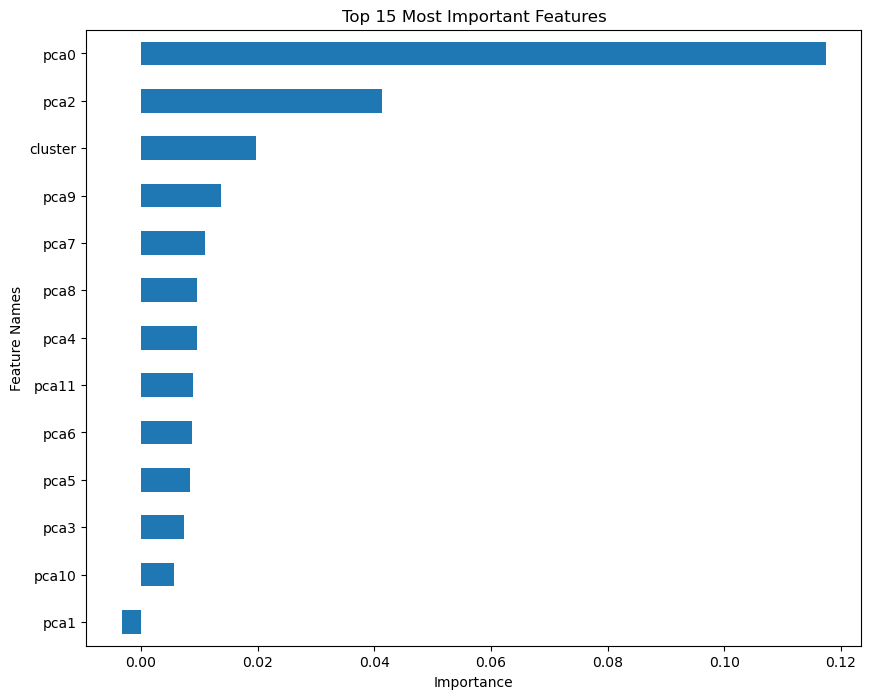

In [89]:
plot_importance_color_ax(permutation_importances_c, top_n=n,
                         figsize=(10,8))

---

We will describe this as model: 4 

---

# Save our best yet Models in a dictionary to call back in the future

In [90]:
model_performance = {
    "Model: 4": "evaluate_classification(knn_psuedo31_c,X_train_pca_c,  y_train_sm, X_test_pca_c, y_test)",
    "Model: 3": "evaluate_classification(knn_psuedo31,X_train_pca, y_train_sm, X_test_pca, y_test)"
}

model_performance

{'Model: 4': 'evaluate_classification(knn_psuedo31_c,X_train_pca_c,  y_train_sm, X_test_pca_c, y_test)',
 'Model: 3': 'evaluate_classification(knn_psuedo31,X_train_pca, y_train_sm, X_test_pca, y_test)'}

# nor corr model without pca, adding k means [ Model: 5 ]

In [91]:
X_test_no_corr.head()

,Age,Income,WaistCirc,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
0,-1.537938,-0.815519,0.093868,-0.366397,-0.158365,0.542706,-0.203517,-0.834719,0.478953,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.297610,-0.165173,1.048489,-0.366397,-0.113280,-0.275901,-0.143737,-0.045041,0.240177,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.354320,-0.165173,0.543101,1.989011,-0.026861,0.610923,-0.323077,3.311091,-0.320426,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.063453,1.443579,0.387117,-0.366397,-0.081855,0.747357,-0.442636,-0.768912,0.177888,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.787211,-0.507461,0.555580,1.989011,0.043952,-0.548769,3.861508,-0.966332,3.499982,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.78      0.89      0.83      1182
   No MetSyn       0.88      0.75      0.81      1182

    accuracy                           0.82      2364
   macro avg       0.83      0.82      0.82      2364
weighted avg       0.83      0.82      0.82      2364



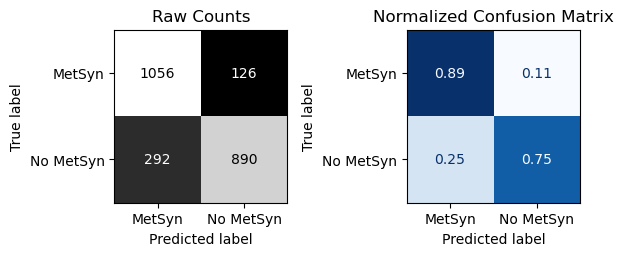


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.62      0.86      0.72       204
   No MetSyn       0.91      0.73      0.81       397

    accuracy                           0.77       601
   macro avg       0.76      0.79      0.77       601
weighted avg       0.81      0.77      0.78       601



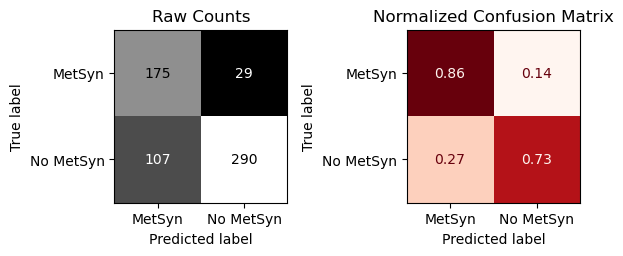

In [92]:
kmeans_ncorr = KMeans(n_clusters=3, n_init= 'auto', random_state=42)
kmeans_ncorr.fit(X_train_no_corr)

#creating new X_train



X_train_ncorr = X_train_no_corr.copy()

# X_train_pca_c = X_train_pca.copy()
X_train_ncorr['cluster'] = kmeans_ncorr.labels_

X_train_ncorr.head()

### creating new X_test


X_test_ncorr = X_test_no_corr.copy()


X_test_ncorr['cluster'] = kmeans_ncorr.predict(X_test_no_corr)


# dedicated prossesor 

num_cols = X_train_ncorr.select_dtypes("number").columns

impute_median = SimpleImputer(strategy= 'median')

num_pipe = make_pipeline(impute_median)

num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

preprocessor_pseudo_ncorr = ColumnTransformer([num_tuple], verbose_feature_names_out=False)
preprocessor_pseudo_ncorr




knn_new31_ncorr = KNeighborsClassifier(n_neighbors=31)

knn_psuedo31_ncorr = make_pipeline(preprocessor_pseudo_ncorr, knn_new31_ncorr)

knn_psuedo31_ncorr.fit(X_train_ncorr, y_train_sm)

evaluate_classification(knn_psuedo31_ncorr,X_train_ncorr,  y_train_sm, X_test_ncorr, y_test)

<Axes: title={'center': 'Top 15 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

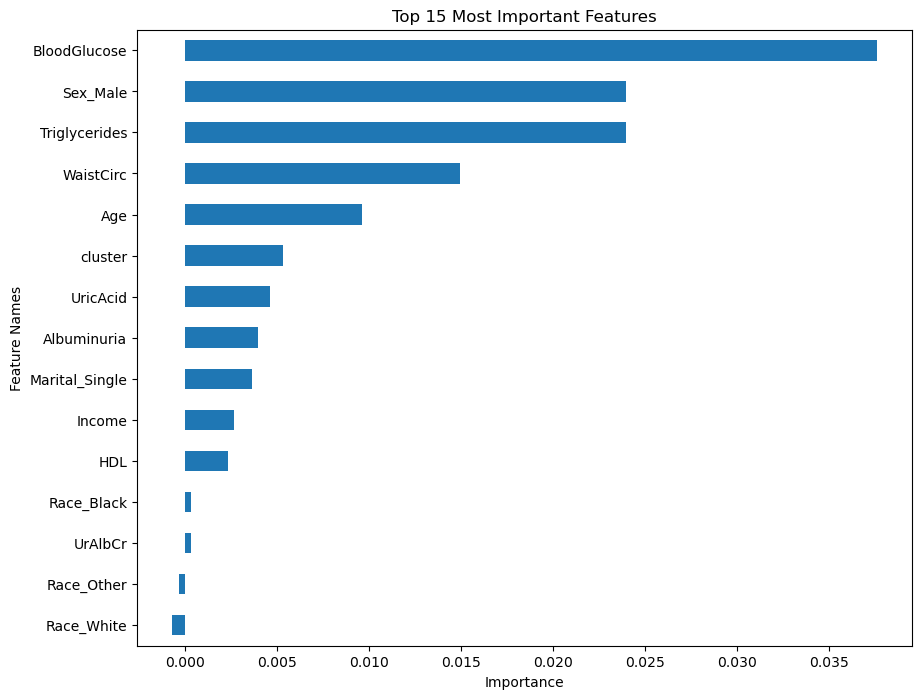

In [93]:
permutation_importances_ncorr = permutation_importance(knn_psuedo31_ncorr , X_test_ncorr, y_test, n_repeats=5, random_state=42)
permutation_importances_ncorr


permutation_importances_ncorr = pd.Series(permutation_importances_ncorr['importances_mean'],index=X_test_ncorr.columns,
                           name = 'permutation importance')

plot_importance_color_ax(permutation_importances_ncorr, top_n=n,
                         figsize=(10,8))




In [94]:
model_performance.update({'Model: 5' : 'evaluate_classification(knn_psuedo31_ncorr,X_train_ncorr,  y_train_sm, X_test_ncorr, y_test)'})

In [95]:
model_performance

{'Model: 4': 'evaluate_classification(knn_psuedo31_c,X_train_pca_c,  y_train_sm, X_test_pca_c, y_test)',
 'Model: 3': 'evaluate_classification(knn_psuedo31,X_train_pca, y_train_sm, X_test_pca, y_test)',
 'Model: 5': 'evaluate_classification(knn_psuedo31_ncorr,X_train_ncorr,  y_train_sm, X_test_ncorr, y_test)'}

# 3d May - Models final evaluation to this point

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.81      0.89      0.85      1182
   No MetSyn       0.88      0.80      0.84      1182

    accuracy                           0.84      2364
   macro avg       0.85      0.84      0.84      2364
weighted avg       0.85      0.84      0.84      2364



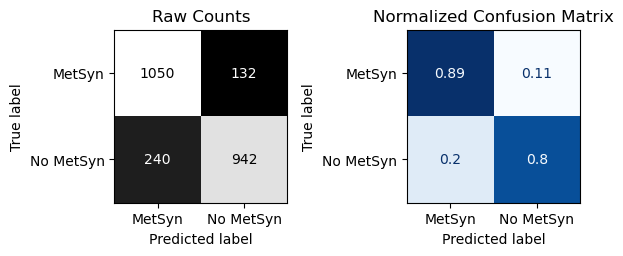


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.67      0.84      0.75       204
   No MetSyn       0.90      0.79      0.84       397

    accuracy                           0.81       601
   macro avg       0.79      0.81      0.79       601
weighted avg       0.83      0.81      0.81       601



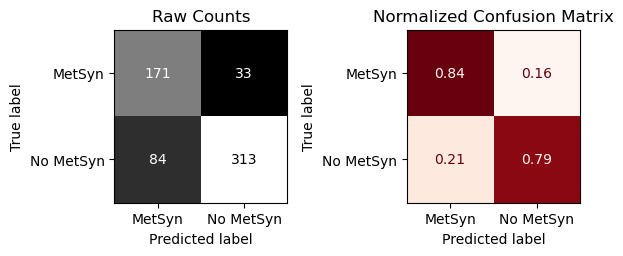

In [96]:
eval(model_performance["Model: 3"])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.80      0.90      0.85      1182
   No MetSyn       0.89      0.77      0.82      1182

    accuracy                           0.84      2364
   macro avg       0.84      0.84      0.83      2364
weighted avg       0.84      0.84      0.83      2364



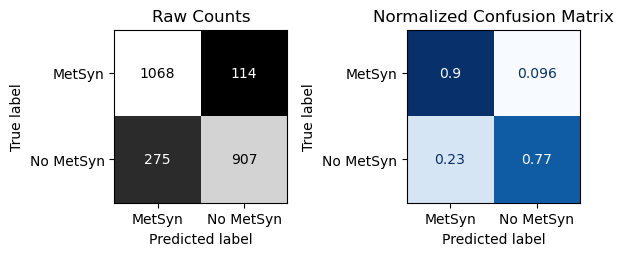


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.63      0.88      0.73       204
   No MetSyn       0.92      0.73      0.81       397

    accuracy                           0.78       601
   macro avg       0.77      0.80      0.77       601
weighted avg       0.82      0.78      0.79       601



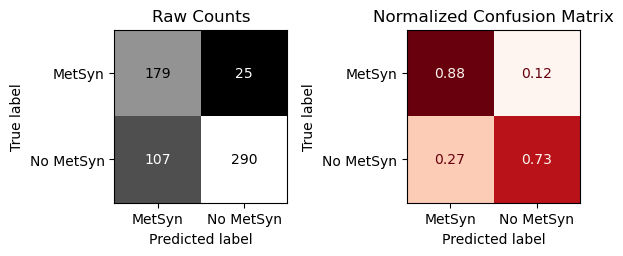

In [97]:
eval(model_performance["Model: 4"])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.78      0.89      0.83      1182
   No MetSyn       0.88      0.75      0.81      1182

    accuracy                           0.82      2364
   macro avg       0.83      0.82      0.82      2364
weighted avg       0.83      0.82      0.82      2364



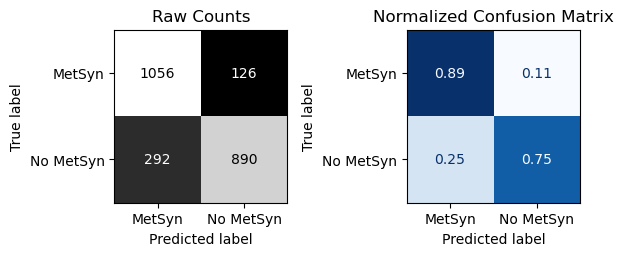


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.62      0.86      0.72       204
   No MetSyn       0.91      0.73      0.81       397

    accuracy                           0.77       601
   macro avg       0.76      0.79      0.77       601
weighted avg       0.81      0.77      0.78       601



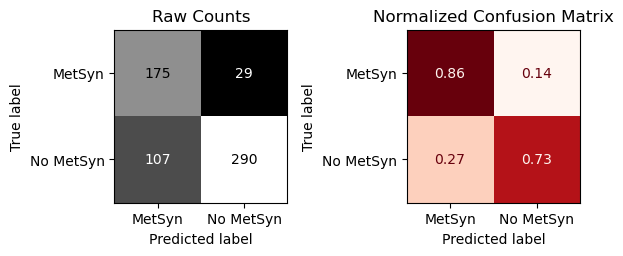

In [98]:
eval(model_performance["Model: 5"])

# results so far 

--- 

- from our observation Model 5 and 3 have the most readable importance.
- and the best performing model and our decision is encouraged by importance readability and metrics at this stage.
- adopting PCAs in our model proved no material enhancement to our model.
- adding the cluster improves the model 5 slightly from model 3 putting it in between 3 and 4 in terms of numaric quality based on metrics.
- we will continue to use Model three previewed previously and lets see its features importance and further explaining why we chose model 3 in the next visualizations

---

## model 5 permutation importance

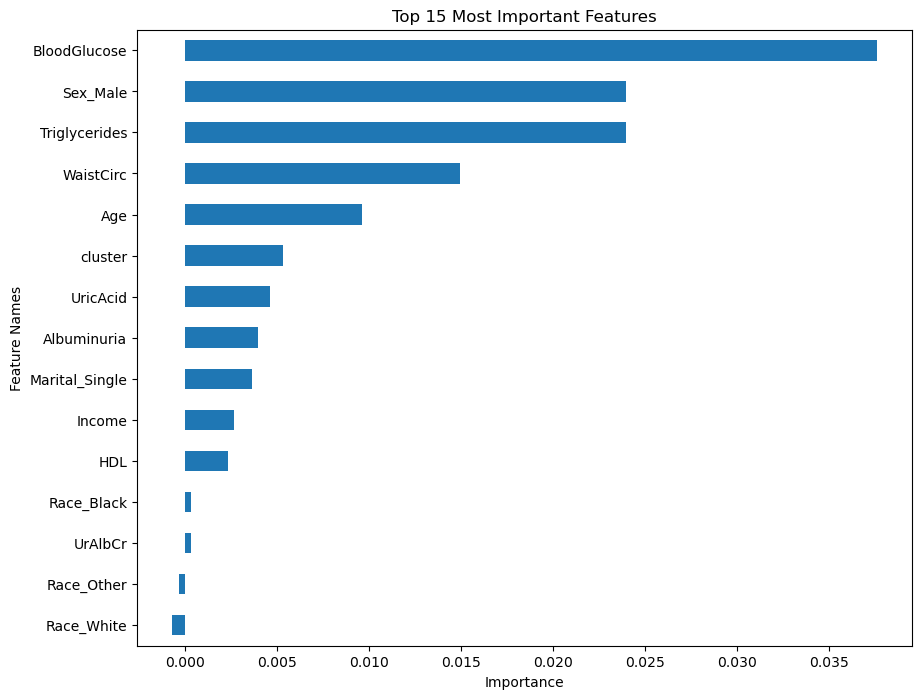

## model 3 permutation importance

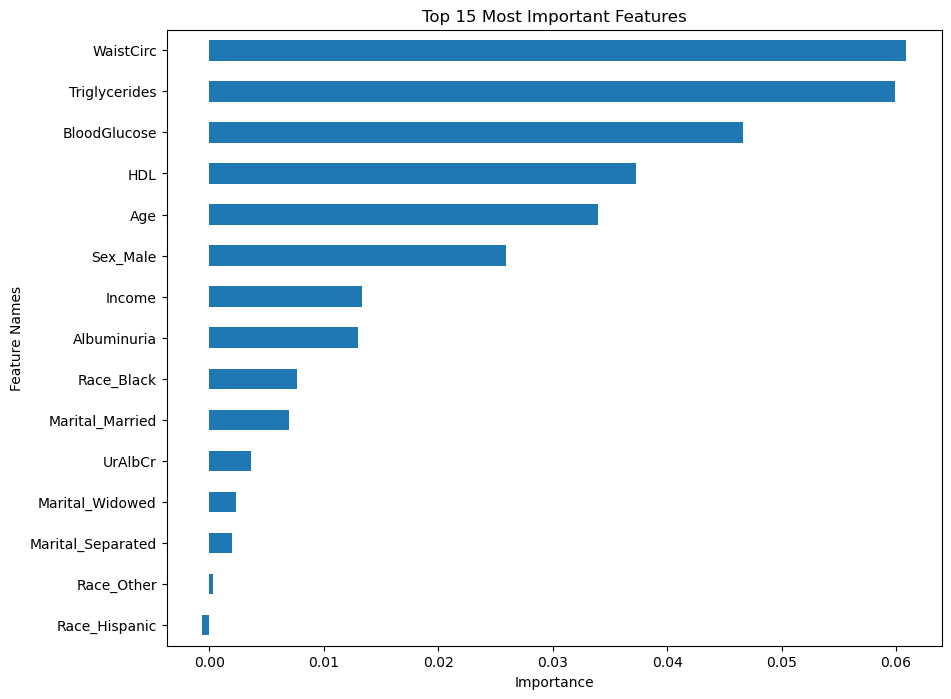

--- 

we can see that the HDL (good cholesterol) has more impact on our predictions, which should be considered in our atleast 5 most important features, rather than the quality that replaced it in model 5, which was if the person is a male, which is also included in model 5 but at a lower importance, and my instictive decision would be using model 3 seeing it relies more on logical and understandable features.

---

# Deep learning 1, Model: 6 (binary_model)

---
 
 ## our features and target
- X_train_no_corr
- X_test_no_corr
- y_train_sm -> y_train_enc
- y_test -> y_test_enc

---

binary classification target problem

---



## target encoding

In [100]:
y.value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [153]:
encoder = LabelEncoder()
 
encoder.fit(y_train)
y_train_enc = encoder.transform(y_train_sm)
y_test_enc = encoder.transform(y_test)
 
# make a record of the classes, in order of the encoding, in case we want to 
# translate predictions into fish names later.
classes = encoder.classes_
 
# # binarize labels
# binarizer = LabelBinarizer()
 
# binarizer.fit(y_train_enc)
# y_train_bin = binarizer.transform(y_train_enc)
# y_test_bin = binarizer.transform(y_test_enc)
 
 
print('\nEncoded Target')
print(y_train_enc[:5])
 
# print('\nBinarized Target')
# print(y_train_bin[:5])



Encoded Target
[0 1 1 1 1]


## imports and functions

In [126]:
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


In [122]:
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes


In [113]:
# # import seaborn as sns
# y_series = pd.Series(y_train_enc)


# print(y_series.describe())
# plt.figure(figsize=(9, 8))
# sns.distplot(y_series, color='g', bins=100, hist_kws={'alpha': 0.4});

## model 6

In [154]:
# Define input shape
input_shape = X_train_no_corr.shape[1]
input_shape


19

In [185]:
def build_model():
     
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(19, 
                    input_dim = input_shape,
                    activation = 'relu')) 

    model.add(Dense(10, 
                activation = 'relu'))
  # model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
   


    model.compile(loss = 'bce', optimizer = 'adam',
              metrics=['accuracy',
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision'),
                        ])
    
    return model



In [186]:
# Call our build function to build model
binary_model = build_model()

# Get model summary
binary_model.summary()



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 19)                380       
                                                                 
 dense_35 (Dense)            (None, 10)                200       
                                                                 
 dense_36 (Dense)            (None, 1)                 11        
                                                                 
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


In [187]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [168]:
X_train_no_corr.shape

(2364, 19)

In [167]:
y_train_enc.shape

(2364,)

In [183]:
np.unique(y_train_enc)

array([0, 1])

In [188]:
# Step 3: Fit our model
history_1 = binary_model.fit(X_train_no_corr, y_train_enc,
                    validation_split = .2, 
                    epochs=50, callbacks = [early_stopping])

Epoch 1/50
60/60 [==============================] - 1s 6ms/step - loss: 0.6718 - accuracy: 0.6113 - recall: 0.8113 - precision: 0.6519 - val_loss: 0.7698 - val_accuracy: 0.3784 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 0.5288 - accuracy: 0.7509 - recall: 0.9019 - precision: 0.7502 - val_loss: 0.6332 - val_accuracy: 0.6321 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 0.4418 - accuracy: 0.7906 - recall: 0.8799 - precision: 0.8037 - val_loss: 0.5770 - val_accuracy: 0.6998 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 0.3982 - accuracy: 0.8234 - recall: 0.8672 - precision: 0.8527 - val_loss: 0.5541 - val_accuracy: 0.7294 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 0.3770 -

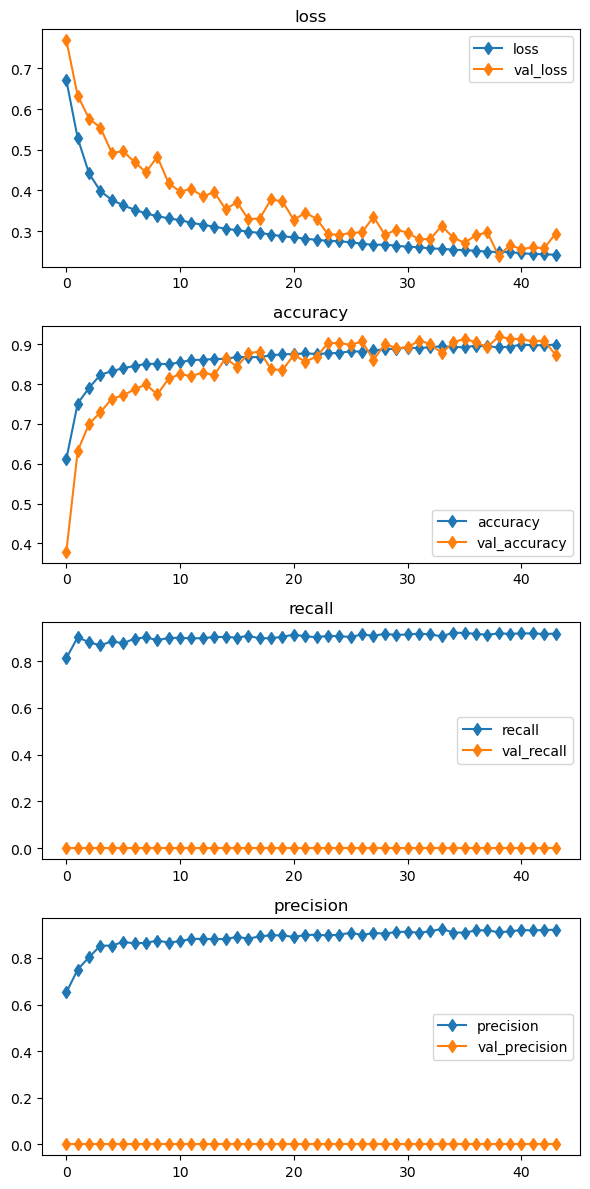

In [189]:
plot_history(history_1, marker='d');

In [262]:
# make predictions
y_pred_train = binary_model.predict(X_train_no_corr)


# round the predictions
y_pred_train = np.round(y_pred_train)


y_pred_test = binary_model.predict(X_test_no_corr)


# round the predictions
y_pred_test = np.round(y_pred_test)


19/19 [==============================] - 0s 888us/step


In [268]:
def model_6(binary_model, X_test_no_corr, y_train_enc, y_pred_train, y_test_enc, y_pred_test):
    # make predictions

    print('-' * 60)
    print('Train data')
    print('-' * 60)
    print(classification_report(y_train_enc, y_pred_train))

    print('-' * 60)
    print('Test data')
    print('-' * 60)
    print(classification_report(y_test_enc, y_pred_test))

    RR = ConfusionMatrixDisplay.from_predictions(y_train_enc, y_pred_train, cmap='Blues',
                                                  normalize='true').ax_.set_title('training data')
    RRR = ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred_test, cmap='Greens',
                                                  normalize='true').ax_.set_title('test data')


------------------------------------------------------------
Train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1182
           1       0.87      0.93      0.90      1182

    accuracy                           0.90      2364
   macro avg       0.90      0.90      0.90      2364
weighted avg       0.90      0.90      0.90      2364

------------------------------------------------------------
Test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       204
           1       0.87      0.90      0.89       397

    accuracy                           0.85       601
   macro avg       0.84      0.82      0.83       601
weighted avg       0.85      0.85      0.85       601



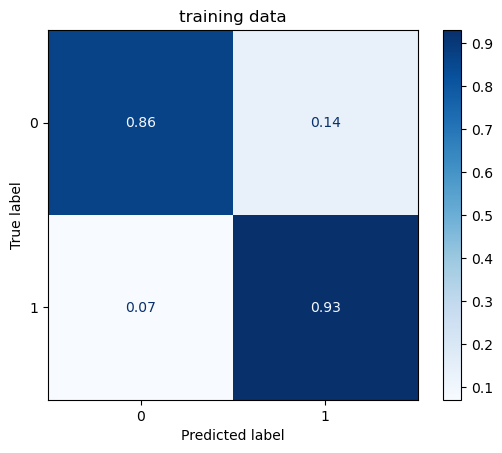

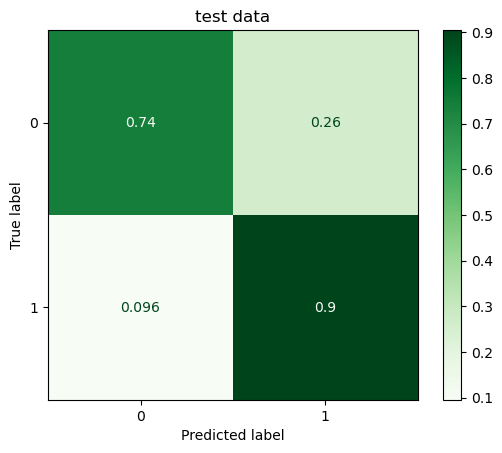

In [269]:
model_6(binary_model, X_test_no_corr, y_train_enc, y_pred_train, y_test_enc, y_pred_test)

In [270]:
model_performance.update({'Model: 6' : 'model_6(binary_model, X_test_no_corr, y_train_enc, y_pred_train, y_test_enc, y_pred_test)'})

# Deep Learning 2, using Tuner (HP), Model: 7 (search_binary_model)

In [230]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt


def build_model(hp):
    # Instantiate Model 
    model = Sequential()
    # First hidden layer
    model.add(Dense(19, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?

    
    # Try different values for units
    model.add(Dense(units=hp.Int('units', min_value=10, max_value=50, step=5), activation='relu'))


    
    # Try different values for dropout rate
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))



    
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile Model
    # Try different optimizers
    model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='bce',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    return model



In [231]:
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)



In [235]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=100,
                     directory=folder,
                     overwrite = True,
                     seed = 42,
                     project_name='Rookie_tuning')



In [236]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [237]:
history_2 = tuner.search(X_train_no_corr, y_train_enc,  epochs=50,
              validation_split = .2, callbacks = [early_stop])

Trial 172 Complete [00h 00m 02s]
val_accuracy: 0.7568710446357727

Best val_accuracy So Far: 0.915433406829834
Total elapsed time: 00h 05m 44s
INFO:tensorflow:Oracle triggered exit


In [241]:
# plot_history(history_2, marker='d');

In [239]:
# Obtain best hyperparameter values
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values



{'units': 35,
 'dropout_value': 0.1,
 'optimizer': 'nadam',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 4,
 'tuner/round': 4,
 'tuner/trial_id': '0143'}

In [254]:
# Obtain best model
search_binary_model = tuner.get_best_models()[0]
search_binary_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19)                380       
                                                                 
 dense_1 (Dense)             (None, 35)                700       
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 36        
                                                                 
Total params: 1,116
Trainable params: 1,116
Non-trainable params: 0
_________________________________________________________________


In [243]:
# Evaluate neural network with built in evaluation
result_tuner = search_binary_model.evaluate(X_test_no_corr, y_test_enc, return_dict=True)
result_tuner

19/19 [==============================] - 0s 2ms/step - loss: 0.3449 - accuracy: 0.8403 - recall: 0.8841 - precision: 0.8753


{'loss': 0.3448789119720459,
 'accuracy': 0.840266227722168,
 'recall': 0.8841309547424316,
 'precision': 0.8753117322921753}

In [249]:
# make predictions
y_pred_train_tuner = search_binary_model.predict(X_train_no_corr)


# round the predictions
y_pred_train_tuner = np.round(y_pred_train_tuner)


74/74 [==============================] - 0s 937us/step


In [250]:
# make predictions
y_pred_test_tuner = search_binary_model.predict(X_test_no_corr)


# round the predictions
y_pred_test_tuner = np.round(y_pred_test_tuner)


19/19 [==============================] - 0s 998us/step


In [271]:
def model_7(y_train_enc, y_pred_train_tuner, y_test_enc, y_pred_test_tuner):
    print('-' * 60)
    print('Train data')
    print('-' * 60)
    print(classification_report(y_train_enc, y_pred_train_tuner))

    print('-' * 60)
    print('Test data')
    print('-' * 60)
    print(classification_report(y_test_enc, y_pred_test_tuner))

    RR_tuner = ConfusionMatrixDisplay.from_predictions(y_train_enc, y_pred_train_tuner, cmap='Blues',
                                                       normalize='true').ax_.set_title('training data')
    RRR_tuner = ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred_test_tuner, cmap='Greens',
                                                        normalize='true').ax_.set_title('test data')

------------------------------------------------------------
Train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1182
           1       0.89      0.91      0.90      1182

    accuracy                           0.90      2364
   macro avg       0.90      0.90      0.90      2364
weighted avg       0.90      0.90      0.90      2364

------------------------------------------------------------
Test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       204
           1       0.88      0.88      0.88       397

    accuracy                           0.84       601
   macro avg       0.82      0.82      0.82       601
weighted avg       0.84      0.84      0.84       601



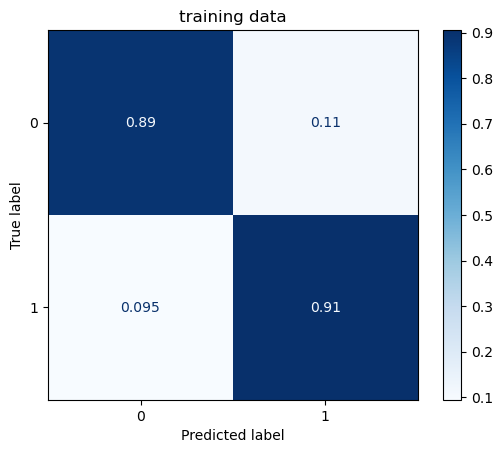

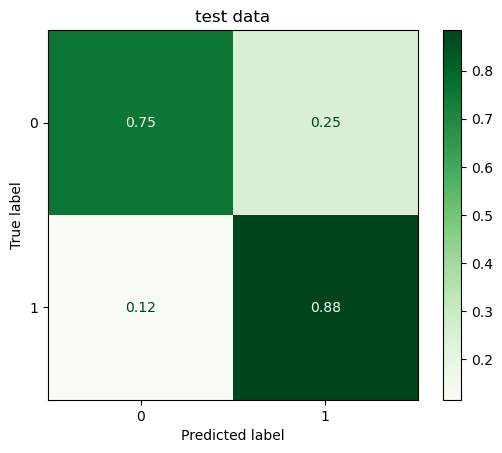

In [272]:
model_7(y_train_enc, y_pred_train_tuner, y_test_enc, y_pred_test_tuner)

In [273]:
model_performance.update({'Model: 7' : 'model_7(y_train_enc, y_pred_train_tuner, y_test_enc, y_pred_test_tuner)'})

In [274]:
model_performance

{'Model: 4': 'evaluate_classification(knn_psuedo31_c,X_train_pca_c,  y_train_sm, X_test_pca_c, y_test)',
 'Model: 3': 'evaluate_classification(knn_psuedo31,X_train_pca, y_train_sm, X_test_pca, y_test)',
 'Model: 5': 'evaluate_classification(knn_psuedo31_ncorr,X_train_ncorr,  y_train_sm, X_test_ncorr, y_test)',
 'Model: 6': 'model_6(binary_model, X_test_no_corr, y_train_enc, y_pred_train, y_test_enc, y_pred_test)',
 'Model: 7': 'model_7(y_train_enc, y_pred_train_tuner, y_test_enc, y_pred_test_tuner)'}

---

model 6 metrics and matrix looks better than model 7, further explanation of why will be addressed later

---

# comparing model: 6 with our previous best model (model: 5)

## Model 5


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.78      0.89      0.83      1182
   No MetSyn       0.88      0.75      0.81      1182

    accuracy                           0.82      2364
   macro avg       0.83      0.82      0.82      2364
weighted avg       0.83      0.82      0.82      2364



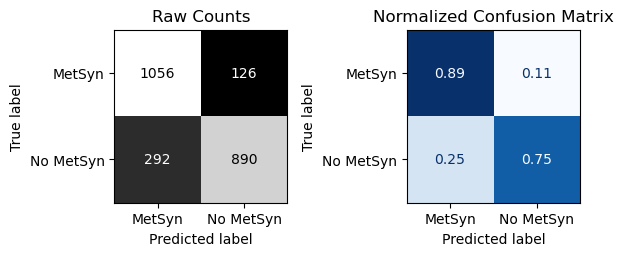


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.62      0.86      0.72       204
   No MetSyn       0.91      0.73      0.81       397

    accuracy                           0.77       601
   macro avg       0.76      0.79      0.77       601
weighted avg       0.81      0.77      0.78       601



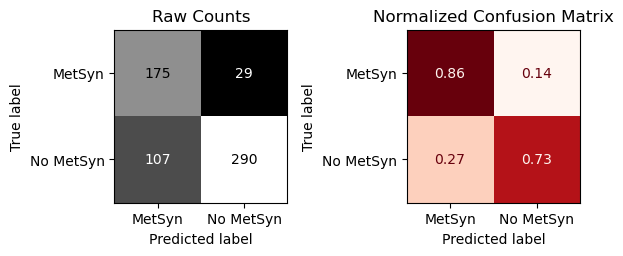

In [267]:
evaluate_classification(knn_psuedo31_ncorr,X_train_ncorr,  y_train_sm, X_test_ncorr, y_test)

## Model 6

------------------------------------------------------------
Train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1182
           1       0.87      0.93      0.90      1182

    accuracy                           0.90      2364
   macro avg       0.90      0.90      0.90      2364
weighted avg       0.90      0.90      0.90      2364

------------------------------------------------------------
Test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       204
           1       0.87      0.90      0.89       397

    accuracy                           0.85       601
   macro avg       0.84      0.82      0.83       601
weighted avg       0.85      0.85      0.85       601



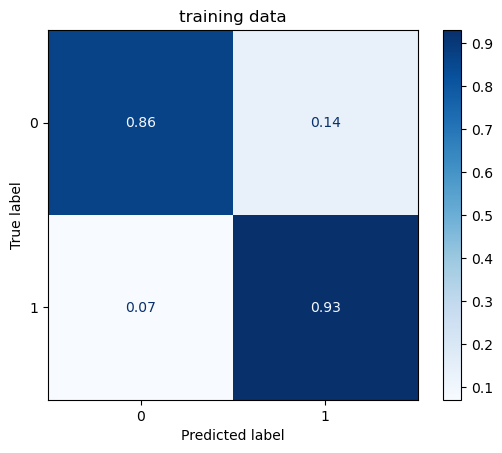

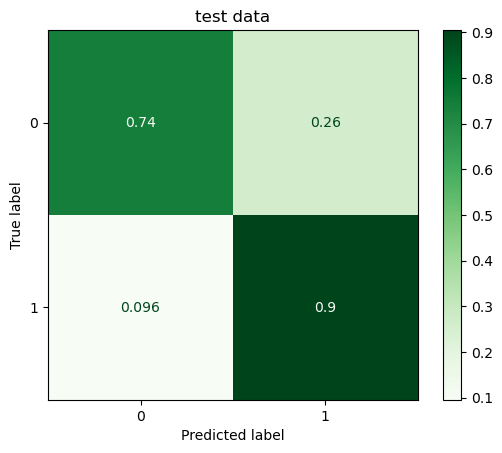

In [277]:
model_6(binary_model, X_test_no_corr, y_train_enc, y_pred_train, y_test_enc, y_pred_test)